### Modularity

Here we will walk through the computation of modularity for a simple graph.

Here is one expression for modularity, from [Fortunato, 2010](https://arxiv.org/pdf/0906.0612.pdf):

$$
Q = \frac{1}{2m}\sum_{ij}(A_{ij} - P_{ij})\delta(C_i,C_j)
$$

where $m$ is the total number of edges in the graph, $A$ is the adjacency matrix, and $P_{ij}$ is the expected number of edges between i and j according to the apporpriate null model, and $\delta$ is a matrix that denotes whether vertices i and j are within the same community:

$$
\delta(C_i,C_j) = \left\{
                \begin{array}{ll}
                  1\ if\ C_i=C_j\\
                  0\ if\ C_i \neq C_j\\
                \end{array}\right.
$$

In [7]:
import numpy
import networkx as nx
import matplotlib.pyplot as plt
import sys

sys.path.append('../utils')
from utils import algorithm_u

%matplotlib inline

First let's create a simple graph that has two communities, each of which is fully connected, with one node from each community connected to a node in the other community.

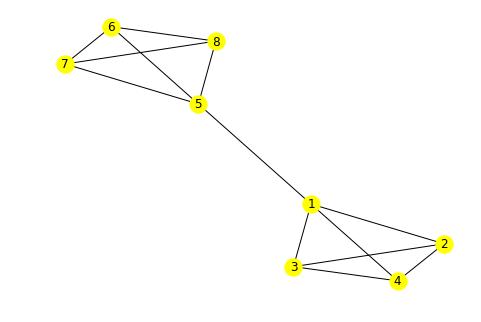

In [10]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges=[(1,2),(1,3),(1,4),(1,5),(5,6),(5,7),(5,8),(6,7),(6,8),(7,8),(2,3),(2,4),(3,4)]
G.add_edges_from(edges)

nx.draw_spring(G,with_labels=True,node_color='yellow')

At a glance this looks like a fairly modular graph. To compute modularity, we first need the adjacency matrix.

In [11]:
A = nx.to_numpy_array(G)
print(A)

[[0. 1. 1. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 1. 0. 1. 1.]
 [0. 0. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0.]]


Next we need to generate the $\delta$ matrix denoting whether each pair of vertices is a member of the same community.

In [12]:
partition = [1,1,1,1,2,2,2,2]
delta = numpy.zeros((len(partition),len(partition)))
for i in range(len(partition)):
    for j in range(len(partition)):
        delta[i,j]=int(partition[i]==partition[j])
        
print(delta)

[[1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1.]]


The final thing we need is the expected edge frequency from the null model.  In general we want the null model to match the actual graph as closely as possible, except for the clustering. It is common to use a null model in which the degree sequence (i.e. the values of degrees for all nodes) is identical to the real graph; this is a more stringent null model than simply equating the degree distribution.  This null model can be written as (Fortunato, 2010):

$$
Q = \frac{1}{2m}\sum_{ij}\bigg(A_{ij} - \frac{k_i k_j}{2m}\bigg)\delta(C_i,C_j)
$$

where $k_i$ is the degree of vertex $i$.  Note that this null model will not necessarily give an identical degree sequence on any particular realization, but should be the same on average.

In [14]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
Q=0
for i in range(len(k)):
    for j in range(len(k)):
        Q += (A[i,j] - (k[i]*k[j])/(2*m))*delta[i,j]
Q = Q/(2*m)

print(Q)

0.42307692307692296


We can compare our answer to the one given by the built-in modularity function in NetworkX:

In [15]:
nx.algorithms.community.quality.modularity(G,[{1,2,3,4},{5,6,7,8}])

0.42307692307692296

Now let's examine how modularity varies with the partition.  In this case, we can fairly easily compute all possible partitions of the 8 nodes and compute modularity for each.  In principle we should see that the modularity value is highest for the true partition.

In [24]:
Qvals=numpy.zeros(128)
partitions=[]
# loop through all possible partitions into two communities:

for i,p in enumerate(algorithm_u([1,2,3,4,5,6,7,8],2)):
    Qvals[i] = nx.algorithms.community.quality.modularity(G,p)
    partitions.append(p)


In [35]:
print('maximum Q:',Qvals.max())
print('best partition:',partitions[numpy.argsort(Qvals)[-1:][0]])

maximum Q: 0.42307692307692296
best partition: [[1, 2, 3, 4], [5, 6, 7, 8]]
